<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SqRA" data-toc-modified-id="SqRA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>SqRA</a></span><ul class="toc-item"><li><span><a href="#Using-full-FG" data-toc-modified-id="Using-full-FG-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Using full FG</a></span></li><li><span><a href="#Using-only-positions" data-toc-modified-id="Using-only-positions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Using only positions</a></span></li><li><span><a href="#Using-only-orientations" data-toc-modified-id="Using-only-orientations-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Using only orientations</a></span></li></ul></li><li><span><a href="#MSM" data-toc-modified-id="MSM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MSM</a></span></li><li><span><a href="#HF--HF" data-toc-modified-id="HF--HF-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>HF -HF</a></span><ul class="toc-item"><li><span><a href="#Pseudotrajectory" data-toc-modified-id="Pseudotrajectory-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Pseudotrajectory</a></span></li></ul></li></ul></div>

In [1]:
import sys
import os

try:
    os.chdir(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup/molgri")
    sys.path.append(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup")
except FileNotFoundError:
    os.chdir(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    sys.path.append(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    
import warnings
warnings.filterwarnings("ignore")

In [59]:
import numpy as np
from scipy.spatial.transform import Rotation
import MDAnalysis as mda
from IPython.core.display import display
import matplotlib.pyplot as plt

from molgri.molecules.parsers import FileParser
from molgri.molecules.writers import PtIOManager
from molgri.molecules.transitions import SimulationHistogram
from molgri.space.fullgrid import FullGrid
from molgri.paths import PATH_INPUT_BASEGRO
from molgri.plotting.widgets import ViewManager, display_all_views, sync_all_views
from molgri.space.rotations import two_vectors2rot
from molgri.space.utils import k_argmax_in_array, k_argmin_in_array
from molgri.plotting.transition_plots import TransitionPlot

## SqRA

In [3]:
fg_full = FullGrid("8", "12", "linspace(0.2, 1, 5)", use_saved=False)
fg_position = FullGrid("1", "12", "linspace(0.2, 1, 5)", use_saved=False)
fg_orientation = FullGrid("8", "1", "1", use_saved=False)

pt_used = "H2O_H2O_0281"


Warning! For <=4 points, volumes, areas etc are only estimated.
Warning! For <=4 points, volumes, areas etc are only estimated.


### Using full FG

False <molgri.space.voronoi.RotobjVoronoi object at 0x7f8f99736010>
In 4D, only approximate calculation of Voronoi cells is possible. Proceeding numerically.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.39it/s]


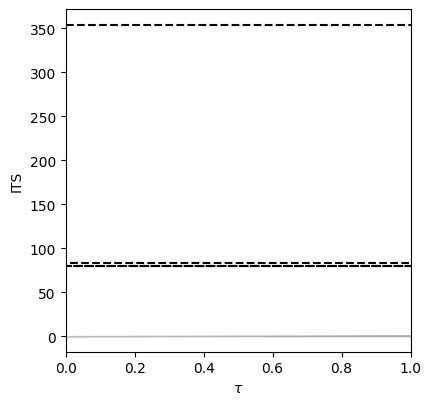

In [4]:
sh = SimulationHistogram(pt_used, is_pt=True, second_molecule_selection="bynum 4:6",
                            full_grid=fg_full, use_saved=False)

tp = TransitionPlot(sh)
tp.plot_its(5, as_line=True, save=False)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.05it/s]


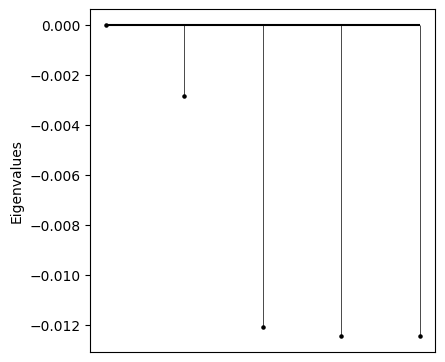

In [5]:
tp.plot_eigenvalues(num_eigenv=5, save=False)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


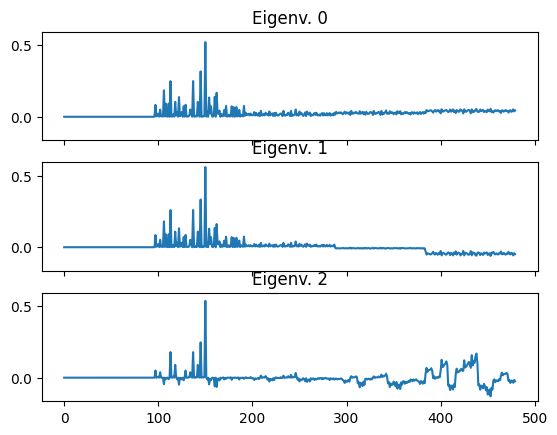

In [6]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i])
plt.show()

In [7]:
# take structures from most populated eigenvector 0 

vm = ViewManager(sh.trajectory_universe)
vm.fresh_view()

# largest absolute values of 0th eigevector
num_extremes = 5
magnitudes = sh.get_magnitude_ith_eigenvector(0)
argmax_index = k_argmax_in_array(np.abs(magnitudes), num_extremes)
print(f"{num_extremes} Most popular cells of FullGrid: {argmax_index}")
# now assign these to trajectory frames
assigned_frames = []
for one_argmax in argmax_index:
    assigned_frames.extend(sh.get_indices_same_cell(one_argmax))


vm.plot_frames_overlapping(assigned_frames)
vm.view

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


5 Most popular cells of FullGrid: [106 113 137 145 150]


NGLWidget()

### Using only positions

Warning! For <=4 points, volumes, areas etc are only estimated.
False <molgri.space.voronoi.RotobjVoronoi object at 0x7f8f99726ad0>


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 244.37it/s]


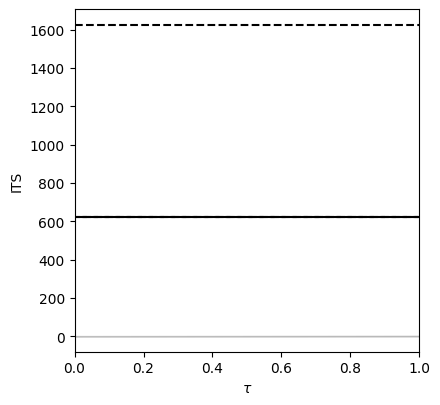

In [8]:
sh = SimulationHistogram(pt_used, is_pt=True, second_molecule_selection="bynum 4:6",
                            full_grid=fg_position, use_saved=False)

tp = TransitionPlot(sh)
tp.plot_its(5, as_line=True, save=False)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 98.16it/s]


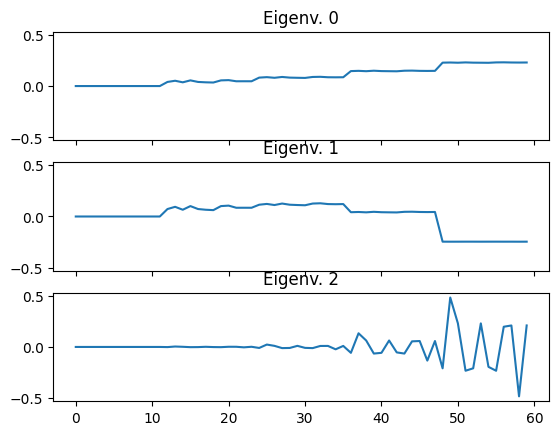

In [9]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i])
plt.show()

In [10]:
# investigate max and min populated eigenv 2
# take structures from most populated eigenvector 0 

vm = ViewManager(sh.trajectory_universe)
vm.fresh_view()
magnitudes = sh.get_magnitude_ith_eigenvector(2)
vm.set_color_magnitude(magnitudes, )
print(magnitudes.shape)

# 
num_extremes = 5
most_positive = np.argmax(magnitudes)
most_negative = np.argmin(magnitudes)
print(f"2nd position eigenvector has most negative cell {most_negative} and most positive cell {most_positive}.")
# now assign these to trajectory frames
assigned_frames = []
colors = []
for one_argmax in [most_negative, most_positive]:
    all_assigned = sh.get_indices_same_cell(one_argmax)
    assigned_frames.extend(all_assigned)
    colors.extend([vm.current_magnitudes[one_argmax]]*len(all_assigned))
vm.current_magnitudes = None

vm.plot_frames_overlapping(assigned_frames, colors=colors)
vm.view

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 97.60it/s]


(60,)
2nd position eigenvector has most negative cell 49 and most positive cell 58.


NGLWidget()

### Using only orientations

Warning! For <=4 points, volumes, areas etc are only estimated.
False <molgri.space.voronoi.MikroVoronoi object at 0x7f8f99559ad0>
In 4D, only approximate calculation of Voronoi cells is possible. Proceeding numerically.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1106.68it/s]


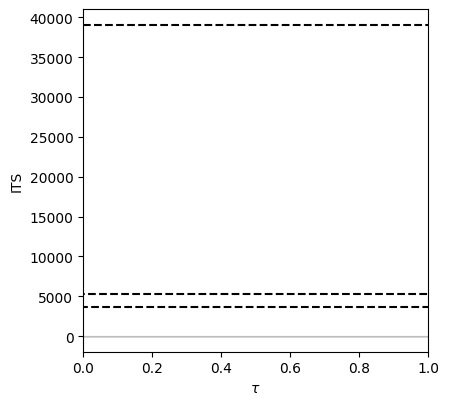

In [11]:
sh = SimulationHistogram(pt_used, is_pt=True, second_molecule_selection="bynum 4:6",
                            full_grid=fg_orientation, use_saved=False)

tp = TransitionPlot(sh)
tp.plot_its(4, as_line=True, save=False)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3132.42it/s]


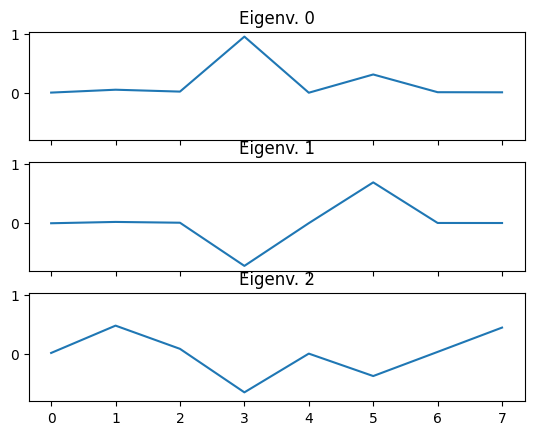

In [12]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i])
plt.show()

In [13]:
# investigate max and min populated eigenv 1
# take structures from most populated eigenvector 0 

vm = ViewManager(sh.trajectory_universe)
vm.fresh_view()
magnitudes = sh.get_magnitude_ith_eigenvector(1)
vm.set_color_magnitude(magnitudes, )

# 
num_extremes = 5
most_positive = np.argmax(magnitudes)
most_negative = np.argmin(magnitudes)
print(f"1st orientation eigenvector has most negative cell {most_negative} and most positive cell {most_positive}.")
# now assign these to trajectory frames
assigned_frames = []
colors = []
for one_argmax in [most_negative, most_positive]:
    all_assigned = sh.get_indices_same_cell(one_argmax)
    assigned_frames.extend(all_assigned)
    colors.extend([vm.current_magnitudes[one_argmax]]*len(all_assigned))
vm.current_magnitudes = None

vm.plot_frames_overlapping(assigned_frames, colors=colors)
vm.view

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3775.25it/s]


1st orientation eigenvector has most negative cell 3 and most positive cell 5.


NGLWidget()

## MSM

In [13]:
traj_used = "H2O_H2O_0095_25000"
sh_traj_full = SimulationHistogram(traj_used, is_pt=False, second_molecule_selection="bynum 4:6",
                            full_grid=fg_full, use_saved=False)

In [14]:
sh_traj_full.get_full_assignments()

array([272, 240, 240, ...,  54,  54,  54])

In [45]:
tau_array=np.array([5, 7, 10, 20, 25, 30, 35, 40, 50, 70, 100, 120, 150, 200, 300, 500, 1000, 2000, 5000])
from molgri.molecules.transitions import MSM
msm = MSM(sh_traj_full, tau_array)
msm.use_saved = False
msm.transition_matrix = None
msm.get_transitions_matrix()
print(msm.transition_matrix.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.22it/s]


(19, 480, 480)


In [46]:
msm.get_eigenval_eigenvec(6);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 59.58it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 54.66it/s]


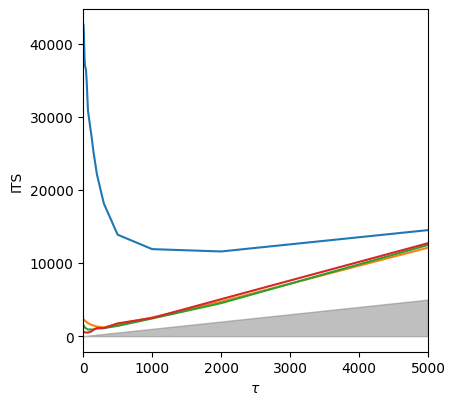

In [52]:
tp = TransitionPlot(sh_traj_full, tau_array)
tp.transition_obj.use_saved = False
tp.transition_obj = msm
tp.plot_its(5, as_line=False, save=False)
#tp.ax.set_ylim(0, 5000)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.62it/s]


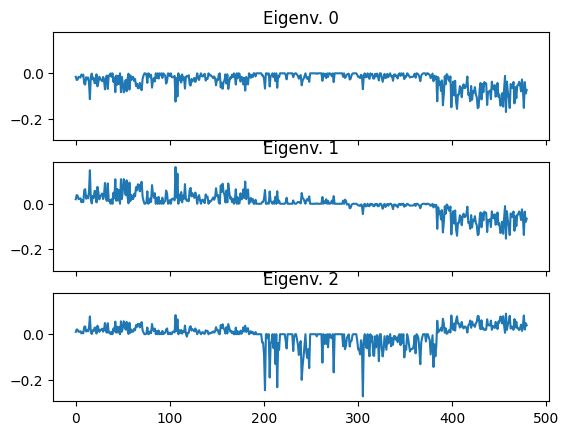

In [53]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i])
plt.show()

In [ ]:
# TODO: try to make quaternion assignments significantly faster
# TODO: network flow plot for strongest rates?

# TODO: make transition matrix determination faster and try it for a large matrix
# TODO: HF forcefield and calculations

## HF -HF

In [63]:
traj_used_ts = "ts_ts"
sh_traj_full_ts = SimulationHistogram(traj_used_ts, is_pt=False, second_molecule_selection="bynum 4:6",
                            full_grid=fg_full, use_saved=False)

In [68]:
# plot 10 lowest energies

# display
vm = ViewManager(sh_traj_full_ts.trajectory_universe)
vm.fresh_view()

# magnitudes
magnitudes = sh_traj_full_ts.get_magnitude_energy("Potential")

num_extremes = 10
argmin_index = k_argmin_in_array(magnitudes, num_extremes)
vm.plot_frames_overlapping(argmin_index, opacities=0.8)

NGLWidget()

In [69]:
sh_traj_full_ts.get_full_assignments()

array([110, 177, 152, ..., 134, 184, 133])

In [71]:
tau_array=np.array([5, 7, 10, 20, 25, 30, 35, 40, 50, 70, 100, 120, 150, 200, 300, 500, 1000, 2000, 5000])
from molgri.molecules.transitions import MSM
msm = MSM(sh_traj_full_ts, tau_array)
msm.get_transitions_matrix();

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  6.14it/s]


In [72]:
msm.get_eigenval_eigenvec(6);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 82.28it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.96it/s]


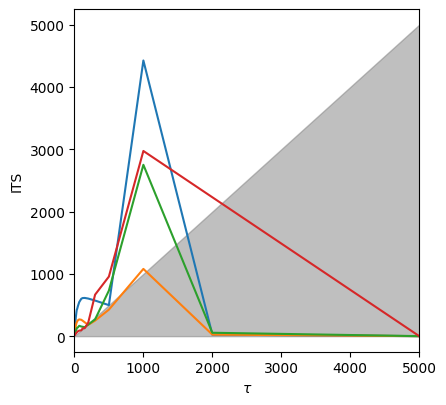

In [86]:
tp = TransitionPlot(sh_traj_full_ts, tau_array)
tp.transition_obj.use_saved = False
tp.transition_obj = msm
tp.plot_its(5, as_line=False, save=False)
#tp.ax.set_ylim(0, 5000)
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 116.87it/s]


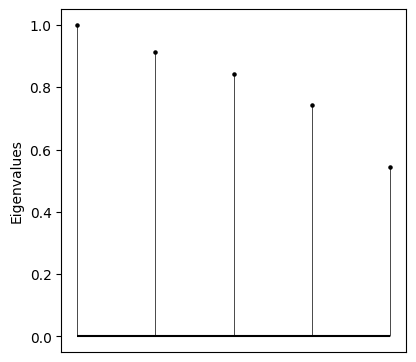

In [89]:
tp.plot_eigenvalues(num_eigenv=5, save=False, index_tau=7)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 79.18it/s]


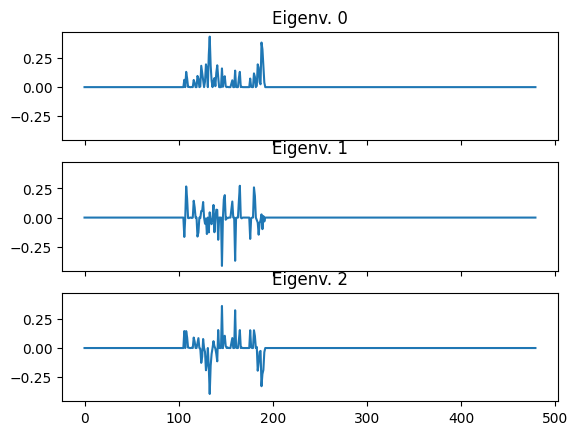

In [93]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i], index_tau=7)
plt.show()

### Pseudotrajectory

In [108]:
pt_used_ts = "ts_ts_0010"
sh_pt_full_ts = SimulationHistogram(pt_used_ts, is_pt=True, second_molecule_selection="bynum 4:6",
                            full_grid=fg_full, use_saved=False)

In [109]:
# plot 10 lowest energies

# display
vm = ViewManager(sh_pt_full_ts.trajectory_universe)
vm.fresh_view()

# magnitudes
magnitudes = sh_pt_full_ts.get_magnitude_energy("Potential")

num_extremes = 20
argmin_index = k_argmin_in_array(magnitudes, num_extremes)
vm.plot_frames_overlapping(argmin_index, opacities=0.8)

NGLWidget()

In [110]:
sh_pt_full_ts.get_full_assignments()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [111]:
from molgri.molecules.transitions import SQRA
sqra = SQRA(sh_pt_full_ts)
rates_matrix = sqra.get_transitions_matrix()

False <molgri.space.voronoi.RotobjVoronoi object at 0x7f86f8e81b10>
In 4D, only approximate calculation of Voronoi cells is possible. Proceeding numerically.


In [113]:
from scipy.constants import k as kB, N_A
import sys
all_energies = np.empty(shape=(len(sqra.sim_hist.full_grid),))
energy_counts = np.zeros(shape=(len(sqra.sim_hist.full_grid),))
obtained_energies = sqra.sim_hist.get_magnitude_energy(energy_type="Potential")
for a, e in zip(sqra.assignments, obtained_energies):
    if not np.isnan(a):
        all_energies[int(a)] += e
        energy_counts[int(a)] += 1
# TODO: need to combine cells that are considered to be separate cells but actually are the same due to symmetry?
# Problem: can't just eliminate them as you would change neighbours, volumes etc ...
# -> one possibility: break symmetry through a different starting structure
# in both cases avoiding division with zero
all_energies = np.divide(all_energies, energy_counts, out=np.zeros_like(all_energies),
                         where=energy_counts != 0)

sqra.get_eigenval_eigenvec(6);

(array([-22842.650391, -22842.412109, -22842.230469, -22842.138672,
       -22841.849609, -22841.402344, -22841.353516, -22841.193359,
       -22841.119141, -22841.064453, -22840.253906, -22840.193359,
       -22839.359375, -22839.201172, -22839.193359, -22839.189453,
       -22839.142578, -22838.845703, -22838.541016, -22838.429688,
       -22838.046875, -22837.880859, -22837.443359, -22837.242188,
       -22837.183594, -22837.021484, -22836.976562, -22836.695312,
       -22836.675781, -22836.498047, -22836.476562, -22836.384766,
       -22836.365234, -22836.300781, -22836.275391, -22836.195312,
       -22835.876953, -22835.808594, -22835.806641, -22835.771484,
       -22835.722656, -22835.621094, -22835.609375, -22835.552734,
       -22835.505859, -22835.462891, -22835.441406, -22835.412109,
       -22835.380859, -22835.357422, -22835.353516, -22835.292969,
       -22835.066406, -22835.027344, -22834.994141, -22834.986328,
       -22834.957031, -22834.949219, -22834.947266, -22834.92

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


In [107]:
# only orientation clases
vm = ViewManager(sh_pt_full_ts.trajectory_universe)
vm.fresh_view()

all_views = []
for i in range(8):
    view = vm.plot_frames_overlapping(sh_pt_full_ts.get_indices_same_orientation(i)[:10], opacities=0.8)
    all_views.append(view)

sync_all_views(all_views)
display_all_views(all_views)

Box(children=(NGLWidget(), NGLWidget(), NGLWidget(), NGLWidget(), NGLWidget(), NGLWidget(), NGLWidget(), NGLWi…

In [ ]:
tp = TransitionPlot(sh_pt_full_ts, tau_array)
tp.plot_its(5, as_line=False, save=False)
#tp.ax.set_ylim(0, 5000)
plt.show()